<a href="https://colab.research.google.com/github/rczhen/faiss_playground/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.pinecone.io/learn/series/faiss/vector-indexes/

This article will explore the pros and cons of some of the most important indexes — Flat, LSH, HNSW, and IVF. We will learn how we decide which to use and the impact of parameters in each index.

We store our vectors in Faiss and query our new Faiss index using a ‘query’ vector. This query vector is compared to other index vectors to find the nearest matches — typically with Euclidean (L2) or inner-product (IP) metrics.

Things to consider:
- Accuracy
- Speed
- Index memory

Indexes
- Flat index (regular KNN). Best quality, lowest speed.
- Locality sensitive hashing (LSH)
- Hierarchical navigable small worlds (HNSW)
- Inverted file index (partitioning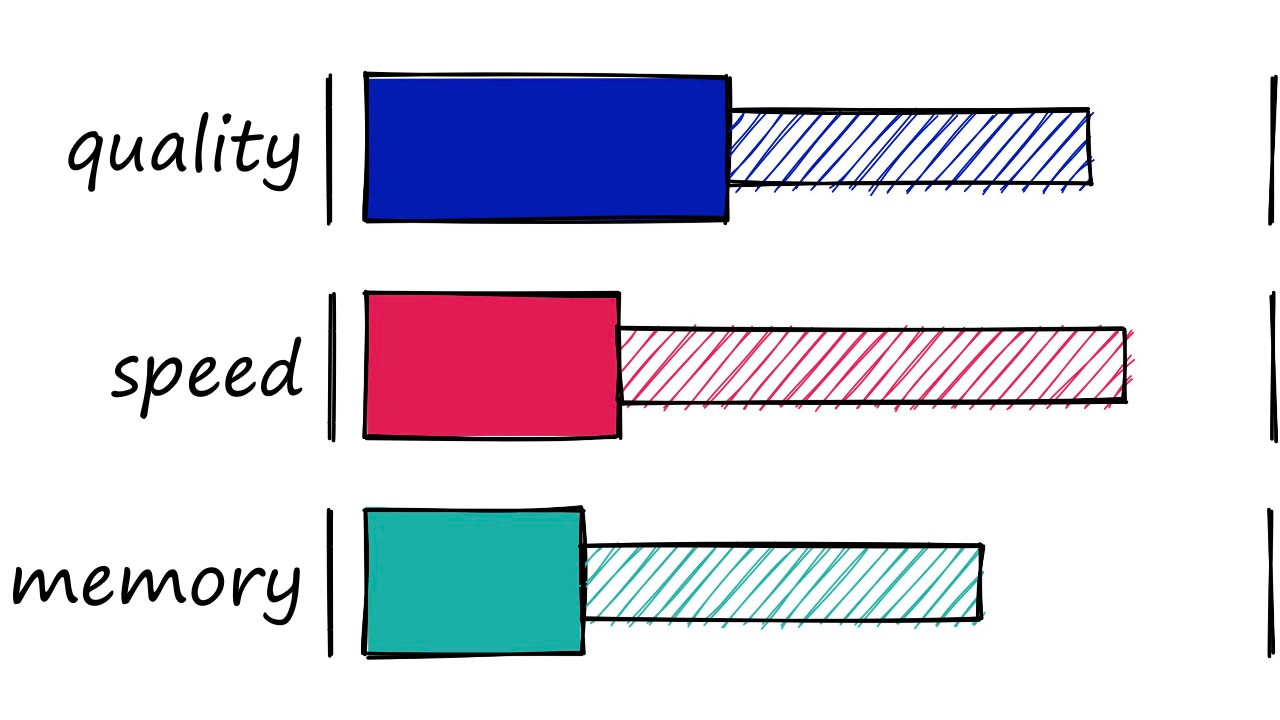)

Use flat indexes when:
- Search quality is a very high priority.
- Search time does not matter OR when using a small index (<10K).


## Datasets for approximate nearest neighbor search

http://corpus-texmex.irisa.fr/


Overview: This page provides several evaluation sets to evaluate the quality of approximate nearest neighbors search algorithm on different kinds of data and varying database sizes.
In particular, we provide a very large set of 1 billion vectors, to our knowledge this is the largest set provided to evaluate ANN methods.

Each comprises 3 subsets of vectors:
- base vectors: the vectors in which the search is performed
- query vectors
- learning vectors: to find the parameters involved in a particular method

In addition, we provide the groundtruth for each set, in the form of the pre-computed k nearest neighbors and their square Euclidean distance.


ANN_SIFT1M:
- dimension: 128
- nb base vectors: 1M
- nb query: 10K
- nb learn vectors: 100K

In [1]:
import shutil
import urllib.request as request
from contextlib import closing

# first we download the Sift1M dataset
with closing(request.urlopen('ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz')) as r:
    with open('sift.tar.gz', 'wb') as f:
        shutil.copyfileobj(r, f)

In [2]:
import tarfile

# the download leaves us with a tar.gz file, we unzip it
tar = tarfile.open('sift.tar.gz', "r:gz")
tar.extractall()

In [3]:
import numpy as np

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

In [6]:
# data we will search through
xb = read_fvecs('./sift/sift_base.fvecs')  # 1M samples
# also get some query vectors to search with
xq = read_fvecs('./sift/sift_query.fvecs')
# take just one query (there are many in sift_learn.fvecs)
xq = xq[0].reshape(1, xq.shape[1])

In [10]:
print(xq.shape)
print(xb.shape)
print(type(xq))

(1, 128)
(1000000, 128)
<class 'numpy.ndarray'>


In [9]:
xq

array([[  1.,   3.,  11., 110.,  62.,  22.,   4.,   0.,  43.,  21.,  22.,
         18.,   6.,  28.,  64.,   9.,  11.,   1.,   0.,   0.,   1.,  40.,
        101.,  21.,  20.,   2.,   4.,   2.,   2.,   9.,  18.,  35.,   1.,
          1.,   7.,  25., 108., 116.,  63.,   2.,   0.,   0.,  11.,  74.,
         40., 101., 116.,   3.,  33.,   1.,   1.,  11.,  14.,  18., 116.,
        116.,  68.,  12.,   5.,   4.,   2.,   2.,   9., 102.,  17.,   3.,
         10.,  18.,   8.,  15.,  67.,  63.,  15.,   0.,  14., 116.,  80.,
          0.,   2.,  22.,  96.,  37.,  28.,  88.,  43.,   1.,   4.,  18.,
        116.,  51.,   5.,  11.,  32.,  14.,   8.,  23.,  44.,  17.,  12.,
          9.,   0.,   0.,  19.,  37.,  85.,  18.,  16., 104.,  22.,   6.,
          2.,  26.,  12.,  58.,  67.,  82.,  25.,  12.,   2.,   2.,  25.,
         18.,   8.,   2.,  19.,  42.,  48.,  11.]], dtype=float32)

## Flat Indexes

In [ ]:
!pip install faiss-cpu

In [21]:
import faiss

d = 128  # dimensionality of Sift1M data
k = 10  # number of nearest neighbors to return

index = faiss.IndexFlatIP(d)
index.add(xb)

# no training (as we have no parameters to optimize when storing vectors without transformations or clustering)

In [20]:
%%time
D, I = index.search(xq, k)

CPU times: user 63.6 ms, sys: 0 ns, total: 63.6 ms
Wall time: 66.3 ms


In [18]:
print(D)
print(I)

[[230843. 230600. 228242. 225288. 225144. 224256. 224214. 223408. 222827.
  222341.]]
[[932085 934876 561813 708177 706771 695756 435345 701258 872728 455537]]


Flat indexes are brilliantly accurate but terribly slow. In similarity search, there is always a trade-off between search-speed and search-quality (accuracy).



So, how can we make our search faster? There are two primary approaches:

1. Reduce vector size — through dimensionality reduction or reducing the number of bits representing our vectors values.
2. Reduce search scope — we can do this by clustering or organizing vectors into tree structures based on certain attributes, similarity, or distance — and restricting our search to closest clusters or filter through most similar branches.

Using either of these approaches means that we are no longer performing an exhaustive nearest-neighbors search but an approximate nearest-neighbors (ANN) search — as we no longer search the entire, full-resolution dataset.

## Locality Sensitive Hashing

Locality Sensitive Hashing (LSH) works by grouping vectors into buckets by processing each vector through a hash function that maximizes hashing collisions — rather than minimizing as is usual with hashing functions.

Why? We use LSH to group similar objects together. When we introduce a new query object (or vector), our LSH algorithm can be used to find the closest matching groups.


LSH — a wide range of performances heavily dependent on the parameters set. Good quality results in slower search, and fast search results in worse quality. Poor performance for high-dimensional data. The ‘half-filled’ segments of the bars represent the range in performance encountered while modifying index parameters.


In [22]:
nbits = d * 4  # resolution of bucketed vectors, (d == 128).
# A higher value means greater accuracy at the cost of more memory and slower search speeds.

index = faiss.IndexLSH(d, nbits)
index.add(xb)

In [27]:
%%time
D, I = index.search(xq, k)

CPU times: user 31.6 ms, sys: 0 ns, total: 31.6 ms
Wall time: 20.7 ms


LSH is highly sensitive to the curse of dimensionality when using a larger d value we also need to increase nbits to maintain search-quality.



So our stored vectors become increasingly larger as our original vector dimensionality d increases. This quickly leads to excessive search times:

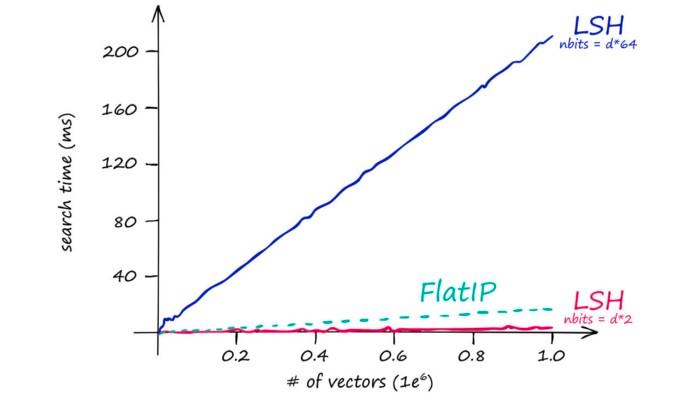

Which is mirrored by our index memory size:

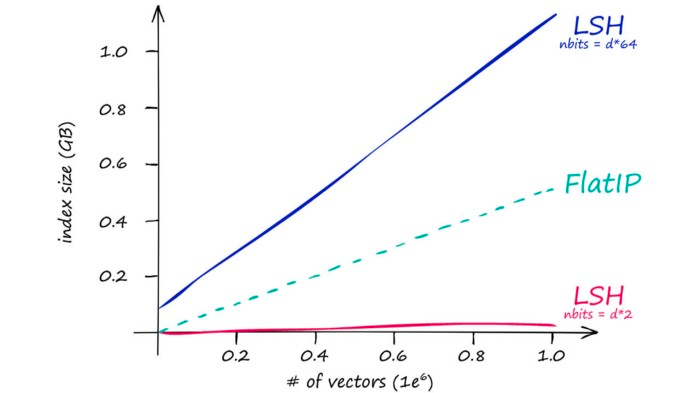

So IndexLSH is not suitable if we have large vector dimensionality (128 is already too large). Instead, it is best suited to low-dimensionality vectors — and small indexes.

If we find ourselves with large d values or large indexes — we use HNSW.

## Hierarchical Navigable Small World (HNSW)

In [28]:
# HNSW index parameters
M = 64  # number of connections each vertex will have
ef_search = 32  # depth of layers explored during search
ef_construction = 64  # depth of layers explored during index construction

index = faiss.IndexHNSWFlat(d, M)  # (d == 128)
# set efConstruction and efSearch parameters
index.hnsw.efConstruction = ef_construction
index.hnsw.efSearch = ef_search

index.add(xb)

In [29]:
%%time
D, I = index.search(xq, k)

CPU times: user 1.07 ms, sys: 0 ns, total: 1.07 ms
Wall time: 1.03 ms


## Inverted File Index (IVF)

In [30]:
nlist = 128  # number of cells/clusters to partition data into

quantizer = faiss.IndexFlatIP(d)  # how the vectors will be stored/compared
index = faiss.IndexIVFFlat(quantizer, d, nlist)

index.train(xb)  # we must train the index to cluster into cells
index.add(xb)

In [31]:
%%time
index.nprobe = 8  # set how many of nearest cells to search
D, I = index.search(xq, k)

CPU times: user 7.99 ms, sys: 994 µs, total: 8.99 ms
Wall time: 7.93 ms
